In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
import spacepy.toolbox as tb

from itertools import tee
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)




This unreleased version of SpacePy is not supported by the SpacePy team.


# Make the split for the polar angle, it is a triangle

In [2]:
def polar_resp(x):
    # outside -5, 5 it is zero
    p11 = np.asarray([-5,0])
    p12 = np.asarray([0,1])
    m1 = (p12[1] - p11[1])/(p12[0] - p11[0])
    
    p21 = np.asarray([5,0])
    p22 = np.asarray([0,1])
    m2 = (p22[1] - p21[1])/(p22[0] - p21[0])
    
    x = np.asanyarray(x)
    ans = np.empty(x.shape, dtype=float)
    ind = np.where(x <= 0)[0]
    try:
        ans[ind] = x[ind]*m1 - m1*p11[0] + p11[1]
    except IndexError:
        ans = x*m1 - m1*p11[0] + p11[1]
    ind = np.where(x > 0)[0]
    try:
        ans[ind] = x[ind]*m2 - m2*p21[0] + p21[1]
    except IndexError:
        if x > 0:
            ans = x*m2 - m2*p21[0] + p21[1]
        else:
            pass
    ans = np.clip(ans, 0, 1e9)
    return ans
    

In [3]:
polar_resp(-4)


0.19999999999999996

[-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2.
  2.5  3.   3.5  4.   4.5  5. ]


(4.999999999999999, 5.5067062021407764e-14)

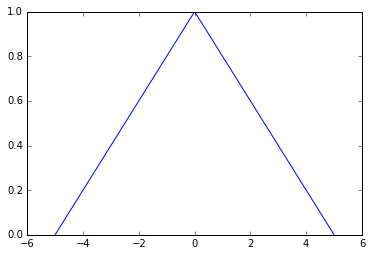

In [4]:
x = np.linspace(-5,5,21)
print(x)
plt.plot(x, polar_resp(x))
quad(polar_resp, -10, 10)

In [5]:
def resp_between_norm(counts, x1, x2, fn=polar_resp):
    return counts*quad(fn, x1, x2)[0]/quad(fn, -5, 5)[0]

print(resp_between_norm(100, -4,-3))

6.0


[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
1.999999999999999
4.999999999999999 489.99999999999994
[  2.   6.  10.  14.  18.  18.  14.  10.   6.   2.]
100.0


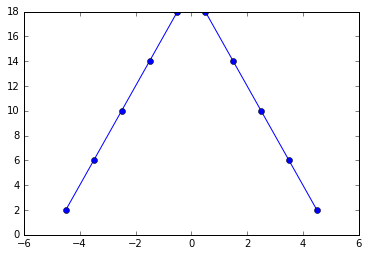

In [14]:
def split_resp_polar(counts, edges):
    ans = np.empty(len(edges)-1, dtype=float)
    for i, (x1, x2) in enumerate(pairwise(edges)):
        ans[i] = resp_between_norm(counts, x1, x2, fn=polar_resp)
    return ans

print(np.linspace(-5,5,11))
print(resp_between_norm(100, -5,-4))
print(quad(polar_resp, -5, 5)[0], 100*quad(polar_resp, -5,4)[0])
edges = np.linspace(-5,5,11)
counts = split_resp_polar(100,edges )
print( counts)
plt.plot(tb.bin_edges_to_center(edges), counts, '-o')
print(sum(counts))

In [7]:
fn=polar_resp
quad(fn, -5, 5)[0]
fn(-6)


0.0

# Make the split for azi, it is gaussian

In [12]:
def azi_resp(x):
    fwhm = 2.0
    mean = -1.0
    t1 = 2*np.sqrt(np.log(2))/(fwhm*np.sqrt(np.pi))
    t2 = -(x-mean)**2
    t3 = 4*np.log(2)/fwhm**2
    return t1*np.exp(t2*t3)


[-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2.
  2.5  3.   3.5  4.   4.5  5. ]
i1 (0.9999987592261852, 4.2669563002151385e-09)
i2 (1.0, 4.273148041182737e-09)
i3 (1.0, 4.2731478885270715e-09)


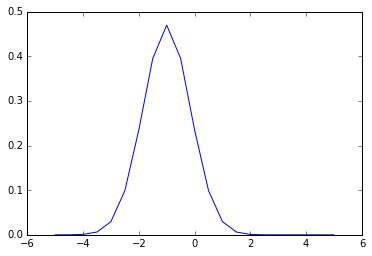

In [15]:
x = np.linspace(-5,5,21)
print(x)
plt.plot(x, azi_resp(x))
print('i1', quad(azi_resp, -5, 5))
print('i2', quad(azi_resp, -10, 10))
print('i3', quad(azi_resp, -20, 20))

In [16]:
def split_resp_azi(counts, edges):
    ans = np.empty(len(edges)-1, dtype=float)
    for i, (x1, x2) in enumerate(pairwise(edges)):
        ans[i] = resp_between_norm(counts, x1, x2, fn=azi_resp)
    return ans


[  2.04794821e-02   9.05981478e-01   1.10250244e+01   3.80484526e+01
   3.80484526e+01   1.10250244e+01   9.05981478e-01   2.04794821e-02
   1.23880880e-04   1.96494390e-07]
100.0


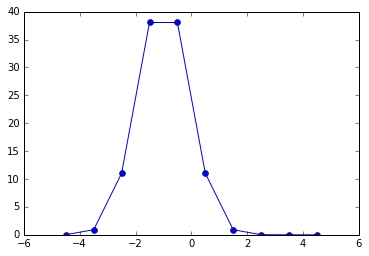

In [17]:
edges = np.linspace(-5,5,11)
counts = split_resp_azi(100,edges )
print( counts)
plt.plot(tb.bin_edges_to_center(edges), counts, '-o')
print(sum(counts))

# Make the resp 2d

In [30]:
def resp_2d(counts, polar_edges, azi_edges, fn_polar=polar_resp, fn_azi=azi_resp):
    ans = np.empty((len(azi_edges)-1, len(polar_edges)-1), dtype=float)
    # compute the azi
    azi_tmp = split_resp_azi(counts, azi_edges)
    # loop over the azi, computing polar
    for i, a_tmp in enumerate(azi_tmp):
        ans[i] = split_resp_polar(a_tmp, polar_edges)
    return ans
    

100.000124077


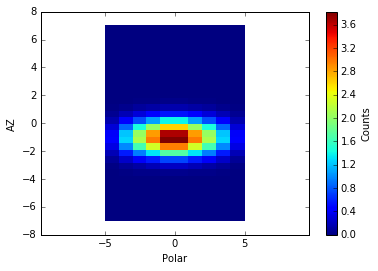

In [40]:
p_edges = np.linspace(-5,5,11)
a_edges = np.linspace(-7,7,31)
ans = resp_2d(100, p_edges, a_edges)
plt.pcolormesh(p_edges, a_edges, ans)
plt.axes().set_aspect('equal', 'datalim')
plt.ylabel('AZ')
plt.xlabel('Polar')
cb = plt.colorbar()
cb.set_label('Counts')
print(ans.sum())